# 11.6 动量法
- **目录**
  - 11.6.1 动量法基础
    - 11.6.1.1 泄漏平均值
    - 11.6.1.2 条件不佳的问题
    - 11.6.1.3 动量法原理
    - 11.6.1.4 有效样本权重
  - 11.6.2 动量法实现实战
    - 11.6.2.1 从零开始实现
    - 11.6.2.2 简洁实现
  - 11.6.3 动量法理论分析
    - 11.6.3.1 二次凸函数
    - 11.6.3.2 标量函数


- 在 11.4节一节中，我们详述了如何执行随机梯度下降，即在只有**嘈杂的梯度**可用的情况下执行优化时会发生什么。
- 对于嘈杂的梯度，我们在选择学习率需要格外谨慎。
  - 如果衰减速度太快，收敛就会停滞。
  - 相反，如果太宽松，我们可能无法收敛到最优解。

-----------
- **说明：嘈杂的梯度或梯度噪声及其影响分析**
  - 嘈杂的梯度（或称为**有噪声的梯度**）是指在计算梯度的过程中引入了随机噪声或者波动。这种现象通常发生在使用随机梯度下降（SGD）或其变体时，因为在每次迭代中只**使用一小批量（mini-batch）的样本来估计整体的梯度**。
  - 有噪声的梯度中的噪声通常不是人为引入的，而是由小批量随机梯度下降算法导致的。
  - 在小批量随机梯度下降（mini-batch SGD）中，每次迭代只使用训练集中的一个小批量样本来估计梯度。
    - 由于这个小批量只是整个训练集的一个**随机子集**，因此计算出的梯度是全局梯度的一个**不完全估计**，尽管小批量梯度的**期望**等于全局梯度（即上一节中的完整梯度）。
    - 这种随机选择造成的**不确定性**和**不一致**就是所谓的“噪声”。
  - 使用整个训练集来计算梯度会得到精确的梯度方向，但这在大数据集的情况下可能非常昂贵和不切实际。
    - 相反，使用小批量随机抽样可以显著提高计算效率，但**代价是引入了梯度估计的噪声**。
    - 这种权衡在许多深度学习优化算法中都是常见的现象。
  - 具体来说，嘈杂的梯度有以下几个特点：
    - 不准确的估计：由于每次只使用小批量样本，所计算的梯度可能与整个数据集上的真实梯度有所偏差。
    - 波动性：随着迭代的进行，由于每次选取的样本批次不同，梯度的计算可能会在不同的方向上波动，导致**优化路径不稳定**。
    - 可能的偏差：如果样本批次的选择有偏差，或者某些类别的样本在批次中被过度表示，可能会导致梯度估计与真实梯度不一致。
  - 嘈杂的梯度可能会导致优化过程变得困难和不稳定，特别是在选择学习率方面。
    - **过小的学习率可能会导致收敛速度过慢，而过大的学习率可能会导致优化过程在最优解附近震荡，难以收敛**。
  - 这就是为什么许多先进的优化算法，如动量法、RMSProp、Adam等，都试图通过不同的策略来缓解这一问题，从而实现**更稳定**和**更快速**的收敛。
  ----------

## 11.6.1 动量法基础

在本节中，我们将探讨更有效的优化算法，尤其是针对实验中常见的某些类型的优化问题。

### 11.6.1.1 泄漏平均值

上一节中我们讨论了小批量随机梯度下降作为加速计算的手段。
它也有很好的副作用，即**平均梯度减小了方差**。
小批量随机梯度下降可以通过以下方式计算：

$$\mathbf{g}_{t, t-1} = \partial_{\mathbf{w}} \frac{1}{|\mathcal{B}_t|} \sum_{i \in \mathcal{B}_t} f(\mathbf{x}_{i}, \mathbf{w}_{t-1}) = \frac{1}{|\mathcal{B}_t|} \sum_{i \in \mathcal{B}_t} \mathbf{h}_{i, t-1} \tag{11.6.1}
$$

为了保持记法简单，在这里我们使用$\mathbf{h}_{i, t-1} = \partial_{\mathbf{w}} f(\mathbf{x}_i, \mathbf{w}_{t-1})$作为样本$i$的随机梯度下降，使用时间$t-1$时更新的权重$t-1$。
如果我们能够**从方差减少的影响中受益**，甚至超过小批量上的梯度平均值，那很不错。
完成这项任务的一种选择是用**泄漏平均值（leaky average）** 取代梯度计算：

$$\mathbf{v}_t = \beta \mathbf{v}_{t-1} + \mathbf{g}_{t, t-1} \tag{11.6.2}$$

其中$\beta \in (0, 1)$。
这有效地将**即时梯度**替换为**多个“过去”梯度的平均值**。
$\mathbf{v}$被称为**动量（momentum）**，
它累加了过去的梯度。
为了更详细地解释，让我们递归地将$\mathbf{v}_t$扩展到

$$\begin{aligned}
\mathbf{v}_t = \beta^2 \mathbf{v}_{t-2} + \beta \mathbf{g}_{t-1, t-2} + \mathbf{g}_{t, t-1}
= \ldots, = \sum_{\tau = 0}^{t-1} \beta^{\tau} \mathbf{g}_{t-\tau, t-\tau-1}.
\end{aligned} \tag{11.6.3}$$

其中，**较大的$\beta$相当于长期平均值，而较小的$\beta$相对于梯度法只是略有修正**。
新的梯度替换不再指向特定实例下降最陡的方向，而是指向**过去梯度的加权平均值的方向**。
这使我们能够实现对单批量计算平均值的大部分好处，而不产生实际计算其梯度的代价。

上述推理构成了"加速"梯度方法的基础，例如**具有动量的梯度**。
在优化问题条件不佳的情况下（例如，有些方向的进展比其他方向慢得多，类似狭窄的峡谷），"加速"梯度还额外享受更有效的好处。
此外，它们允许我们对随后的梯度计算平均值，以获得更稳定的下降方向。
诚然，即使是对于无噪声凸问题，加速度这方面也是动量如此起效的关键原因之一。

正如人们所期望的，由于其功效，动量是深度学习及其后优化中一个深入研究的主题。
例如，请参阅[文章](https://distill.pub/2017/momentum/)，观看深入分析和互动动画。

- **要点：**
  - **小批量随机梯度下降**：
    - 小批量随机梯度下降（mini-batch SGD）作为一种加速计算手段。
    - 通过平均小批量中的梯度，降低了方差，使梯度估计更准确。    
  - **泄漏平均值（Leaky Average）**：
    - 通过泄漏平均值更好地利用方差减少的影响。
    - 泄漏平均值使用过去梯度的平均值，而不是即时梯度。    
  - **动量（Momentum）**：
    - 动量累加了过去的梯度
    - 更大的$\beta$ 实现了长期平均，较小的$\beta$则对梯度法进行略微修正。
  - **“加速”梯度方法**：
    - 在优化问题条件不佳时（例如，某些方向的进展慢得多），加速梯度的效果更显著。
    - 允许对后续梯度进行平均，实现更稳定的下降方向。
  - **深入研究和应用**：
    - 动量是深度学习及其后优化中一个深入研究的主题。
    - 无论是有噪声的非凸问题还是无噪声的凸问题，动量都表现出良好的效果。


- **示例：公式11.6.2中的动量实现**

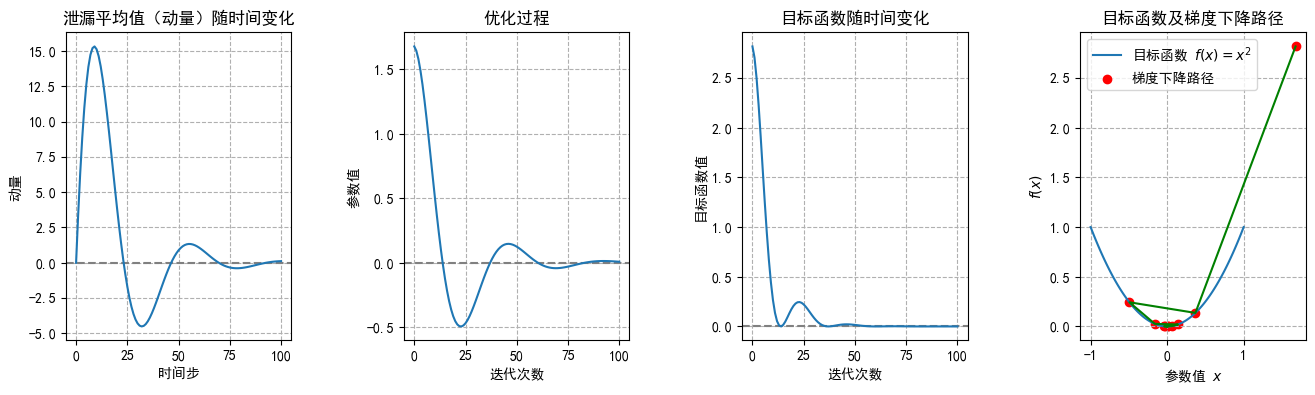

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif'] = ['SimHei']  # 指定默认字体为黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像时'-'显示为方块的问题

# 目标函数的梯度
def gradient(x):
    return 2 * x

# 目标函数
def loss(x):
    return x**2

# 使用动量进行优化
def optimize_with_momentum(lr=0.01, beta=0.9, epochs=100, batch_size=10):
    x = np.random.randn()  # 随机初始化
    v = 0  # 初始化动量
    history = [x]  # 记录参数值
    v_history = [v]  # 记录动量值
    loss_history = [loss(x)]  # 记录损失值
    for epoch in range(epochs):
        # 模拟小批量随机梯度下降
        mini_batch_gradient = 0
        for i in range(batch_size):
            mini_batch_gradient += gradient(x)
        mini_batch_gradient /= batch_size

        # 计算泄漏平均值（动量）：公式11.6.2
        v = beta * v + mini_batch_gradient
        v_history.append(v)

        # 更新参数
        x -= lr * v
        history.append(x)

        # 记录损失值(本例为目标函数)
        loss_history.append(loss(x))
    return history, v_history, loss_history

# 优化并输出结果
history, v_history, loss_history = optimize_with_momentum()

# 绘制结果
plt.figure(figsize=[16, 4])

# 第一个图：动量随时间变化
plt.subplot(1, 4, 1)
plt.axhline(y=0, color='gray', linestyle='--')
plt.grid(True, linestyle='--')
sns.lineplot(x=range(len(v_history)), y=v_history)
plt.title('泄漏平均值（动量）随时间变化')
plt.xlabel('时间步')
plt.ylabel('动量')

# 第二个图：参数值随时间变化
plt.subplot(1, 4, 2)
plt.axhline(y=0, color='gray', linestyle='--')
plt.grid(True, linestyle='--')
sns.lineplot(x=range(len(history)), y=history)
plt.title('优化过程')
plt.xlabel('迭代次数')
plt.ylabel('参数值')

# 第三个图：损失值随时间变化
plt.subplot(1, 4, 3)
plt.axhline(y=0, color='gray', linestyle='--')
plt.grid(True, linestyle='--')
sns.lineplot(x=range(len(loss_history)), y=loss_history)
plt.title('目标函数随时间变化')
plt.xlabel('迭代次数')
plt.ylabel('目标函数值')

# 第四个图：目标函数曲线及梯度下降路径
plt.subplot(1, 4, 4)
x_values = np.linspace(-1, 1, 100)
y_values = loss(x_values)
plt.plot(x_values, y_values, label='目标函数 $f(x) = x^2$')  # 目标函数曲线

# 绘制梯度下降路径
path_indices = np.linspace(0, len(history) - 1, 10, dtype=int)  # 均匀选择10个点
path_x = [history[i] for i in path_indices]
path_y = [loss(history[i]) for i in path_indices]
plt.scatter(path_x, path_y, color='red', label='梯度下降路径')  # 路径点
plt.plot(path_x, path_y, color='green', linestyle='-')  # 路径连线

plt.title('目标函数及梯度下降路径')
plt.xlabel('参数值 $x$')
plt.ylabel('$f(x)$')
plt.legend()
plt.grid(True, linestyle='--')

plt.subplots_adjust(wspace=0.5)  
plt.show()

### 11.6.1.2 条件不佳的问题

- 为了更好地了解动量法的几何属性，我们复习一下梯度下降，尽管它的目标函数明显不那么令人愉快。
- 回想我们在 11.3节中使用了$f(\mathbf{x}) = x_1^2 + 2 x_2^2$，即中度扭曲的椭球目标。
- 我们通过向$x_1$方向伸展它来进一步扭曲这个函数
$$f(\mathbf{x}) = 0.1 x_1^2 + 2 x_2^2 \tag{11.6.4}$$
  - 与之前一样，$f$在$(0, 0)$有最小值，
  - 该函数在$x_1$的方向上**非常平坦**。
 
<center><img src='../img/11_6_1.png' width=500px></center> 
<center>图11.6.1 不那么令人愉快的目标函数</center>

- 让我们看看在这个新函数上执行梯度下降时会发生什么。

epoch 20, x1: -0.943467, x2: -0.000073


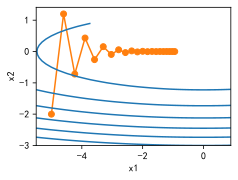

In [19]:
%matplotlib inline
import torch
from d2l import torch as d2l

eta = 0.4
def f_2d(x1, x2):
    return 0.1 * x1 ** 2 + 2 * x2 ** 2
def gd_2d(x1, x2, s1, s2):
    return (x1 - eta * 0.2 * x1, x2 - eta * 4 * x2, 0, 0)

d2l.show_trace_2d(f_2d, d2l.train_2d(gd_2d))

- 从构造来看，$x_2$方向的梯度比水平$x_1$方向的**梯度大得多，变化也快得多**。
- 因此，我们陷入两难：
  - 如果选择较小的学习率，会确保解不会在$x_2$方向发散，但要承受在$x_1$方向的缓慢收敛。
  - 如果学习率较高，**在$x_1$方向上进展很快，但在$x_2$方向将会发散**。
- 下面的例子说明了即使学习率从$0.4$略微提高到$0.6$，也会发生变化。
- $x_1$方向上的收敛有所改善，但整体来看解的质量更差了。


epoch 20, x1: -0.387814, x2: -1673.365109


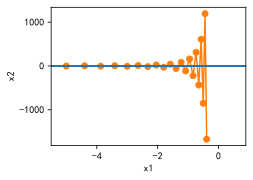

In [20]:
eta = 0.6
d2l.show_trace_2d(f_2d, d2l.train_2d(gd_2d))

### 11.6.1.3 动量法原理

- **动量法（momentum）** 使我们能够解决上面描述的梯度下降问题。
观察上面的优化轨迹，我们可能会直觉到计算过去的平均梯度效果会很好。
- 毕竟，在$x_1$方向上，这将聚合非常对齐的梯度，从而增加我们在每一步中覆盖的距离。
- 相反，在梯度振荡的$x_2$方向，由于相互抵消了对方的振荡，聚合梯度将减小步长大小。
- 使用$\mathbf{v}_t$而不是梯度$\mathbf{g}_t$可以生成以下更新等式：
$$
\begin{aligned}
\mathbf{v}_t &\leftarrow \beta \mathbf{v}_{t-1} + \mathbf{g}_{t, t-1}, \\
\mathbf{x}_t &\leftarrow \mathbf{x}_{t-1} - \eta_t \mathbf{v}_t
\end{aligned}  \tag{11.6.5}
$$
- 请注意，对于$\beta = 0$，我们恢复常规的梯度下降。
- 在深入研究它的数学属性之前，让我们快速看一下算法在实验中的表现如何。


epoch 20, x1: 0.007188, x2: 0.002553


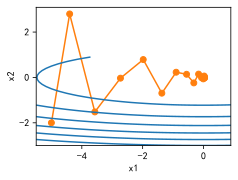

In [21]:
def momentum_2d(x1, x2, v1, v2):
    v1 = beta * v1 + 0.2 * x1
    v2 = beta * v2 + 4 * x2
    return x1 - eta * v1, x2 - eta * v2, v1, v2

eta, beta = 0.6, 0.5
d2l.show_trace_2d(f_2d, d2l.train_2d(momentum_2d))

In [5]:
#d2l.train_2d??

In [6]:
#d2l.show_trace_2d??

- 正如所见，尽管学习率与我们以前使用的相同，动量法仍然很好地收敛了。
- 让我们看看当降低动量参数时会发生什么。
  - 将其减半至$\beta = 0.25$会导致一条几乎没有收敛的轨迹。
  - 尽管如此，它比没有动量时解将会发散要好得多。


epoch 20, x1: -0.126340, x2: -0.186632


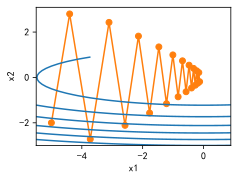

In [22]:
eta, beta = 0.6, 0.25
d2l.show_trace_2d(f_2d, d2l.train_2d(momentum_2d))

- 请注意，可将动量法与随机梯度下降，特别是小批量随机梯度下降结合起来。
- 唯一的变化是，在这种情况下，我们将梯度$\mathbf{g}_{t, t-1}$替换为$\mathbf{g}_t$。
- 为了方便起见，<b>可在时间$t=0$初始化$\mathbf{v}_0 = 0$</b>。

### 11.6.1.4 有效样本权重

- 回想一下$\mathbf{v}_t = \sum_{\tau = 0}^{t-1} \beta^{\tau} \mathbf{g}_{t-\tau, t-\tau-1}$。
  - 极限条件下，$\sum_{\tau=0}^\infty \beta^\tau = \frac{1}{1-\beta}$。
  - 换句话说，不同于在梯度下降或者随机梯度下降中取步长$\eta$，我们<b>选取步长$\frac{\eta}{1-\beta}$</b>，同时处理潜在表现可能会更好的下降方向。

- 这是集两种好处于一身的做法。
- 为了说明$\beta$的不同选择的权重效果如何，请参考下面的图表。

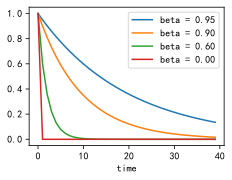

In [23]:
d2l.set_figsize()
betas = [0.95, 0.9, 0.6, 0]
for beta in betas:
    x = torch.arange(40).detach().numpy()
    d2l.plt.plot(x, beta ** x, label=f'beta = {beta:.2f}')
d2l.plt.xlabel('time')
d2l.plt.legend();

- 求解：$\sum_{\tau=0}^\infty \beta^\tau = \frac{1}{1-\beta}$

In [9]:
import sympy as sp

# 定义符号变量
beta, tau = sp.symbols('beta tau')
# 定义无穷级数
series = sp.Sum(beta**tau, (tau, 0, sp.oo))
# 计算级数的和
result = series.doit()

# 打印结果
result

Piecewise((1/(1 - beta), Abs(beta) < 1), (Sum(beta**tau, (tau, 0, oo)), True))

## 11.6.2 动量法实现实验

- 让我们来看看动量法在实验中是如何运作的。
- 为此，我们需要一个更加可扩展的实现。

### 11.6.2.1 从零开始实现

- 相比于小批量随机梯度下降，动量方法需要维护一组辅助变量，即**速度**。
- 它与梯度以及优化问题的变量**具有相同的形状**。
- 在下面的实现中，我们称这些变量为`states`。

In [24]:
def init_momentum_states(feature_dim):
    v_w = torch.zeros((feature_dim, 1))
    v_b = torch.zeros(1)
    return (v_w, v_b)

In [25]:
def sgd_momentum(params, states, hyperparams):
    for p, v in zip(params, states):
        with torch.no_grad():
            v[:] = hyperparams['momentum'] * v + p.grad
            p[:] -= hyperparams['lr'] * v
        p.grad.data.zero_()

- 看看它在实验中是如何运作的。


loss: 0.243, 0.017 sec/epoch


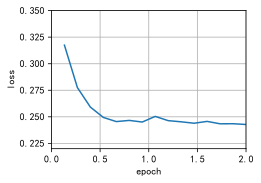

In [26]:
def train_momentum(lr, momentum, num_epochs=2):
    d2l.train_ch11(sgd_momentum, init_momentum_states(feature_dim),
                   {'lr': lr, 'momentum': momentum}, data_iter,
                   feature_dim, num_epochs)

data_iter, feature_dim = d2l.get_data_ch11(batch_size=10)
train_momentum(0.02, 0.5)

In [13]:
#d2l.train_ch11??

- 当我们将动量超参数`momentum`增加到0.9时，它相当于有效样本数量增加到$\frac{1}{1 - 0.9} = 10$。
  - 具体来说是历史梯度的累积效应被放大了 10 倍。
  - 更新步长的有效尺度为$\eta \cdot 10$，比普通梯度下降更大。
- 我们将学习率略微降至$0.01$，以确保可控。


loss: 0.249, 0.020 sec/epoch


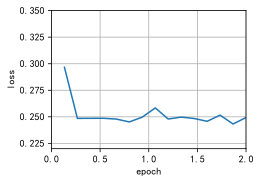

In [27]:
train_momentum(0.01, 0.9)

- 降低学习率进一步解决了任何**非平滑优化问题**的困难，将其设置为$0.005$会产生良好的收敛性能。


loss: 0.243, 0.017 sec/epoch


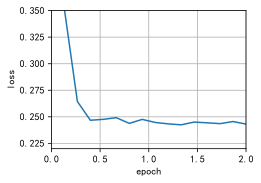

In [28]:
train_momentum(0.005, 0.9)

### 11.6.2.2 简洁实现

- 由于深度学习框架中的优化求解器早已构建了动量法，设置匹配参数会产生非常类似的轨迹。


loss: 0.252, 0.035 sec/epoch


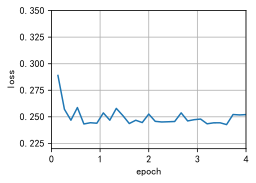

In [29]:
trainer = torch.optim.SGD
d2l.train_concise_ch11(trainer, {'lr': 0.005, 'momentum': 0.9}, data_iter)

In [18]:
#torch.optim.SGD??

## 11.6.3 动量法理论分析

- $f(x) = 0.1 x_1^2 + 2 x_2^2$的2D示例似乎相当牵强。
- 下面我们将看到，它在实际生活中非常具有代表性，至少**最小化凸二次目标函数**的情况下是如此。

### 11.6.3.1 二次凸函数

考虑这个函数

$$h(\mathbf{x}) = \frac{1}{2} \mathbf{x}^\top \mathbf{Q} \mathbf{x} + \mathbf{x}^\top \mathbf{c} + b \tag{11.6.6}$$

这是一个普通的二次函数。
对于正定矩阵$\mathbf{Q} \succ 0$，即对于具有**正特征值的矩阵**，有最小化器为$\mathbf{x}^* = -\mathbf{Q}^{-1} \mathbf{c}$，最小值为$b - \frac{1}{2} \mathbf{c}^\top \mathbf{Q}^{-1} \mathbf{c}$。
因此我们可以将$h$重写为：

$$h(\mathbf{x}) = \frac{1}{2} (\mathbf{x} - \mathbf{Q}^{-1} \mathbf{c})^\top \mathbf{Q} (\mathbf{x} - \mathbf{Q}^{-1} \mathbf{c}) + b - \frac{1}{2} \mathbf{c}^\top \mathbf{Q}^{-1} \mathbf{c} \tag{11.6.7}$$
(注：此步骤使用了**配平方法(completing the square)**)

梯度由$\partial_{\mathbf{x}} f(\mathbf{x}) = \mathbf{Q} (\mathbf{x} - \mathbf{Q}^{-1} \mathbf{c})$给出。
也就是说，它是由$\mathbf{x}$和最小化器之间的距离乘以$\mathbf{Q}$所得出的。
因此，动量法还是$\mathbf{Q} (\mathbf{x}_t - \mathbf{Q}^{-1} \mathbf{c})$的线性组合。

由于$\mathbf{Q}$是正定的，因此可以通过$\mathbf{Q} = \mathbf{O}^\top \boldsymbol{\Lambda} \mathbf{O}$分解为正交（旋转）矩阵$\mathbf{O}$和正特征值的对角矩阵$\boldsymbol{\Lambda}$。
这使我们能够将变量从$\mathbf{x}$更改为$\mathbf{z} := \mathbf{O} (\mathbf{x} - \mathbf{Q}^{-1} \mathbf{c})$，以获得一个非常简化的表达式：

$$h(\mathbf{z}) = \frac{1}{2} \mathbf{z}^\top \boldsymbol{\Lambda} \mathbf{z} + b' \tag{11.6.8}$$
(注：公式11.6.8的推导使用了变量替换)

这里$b' = b - \frac{1}{2} \mathbf{c}^\top \mathbf{Q}^{-1} \mathbf{c}$。
由于$\mathbf{O}$只是一个正交矩阵，因此**不会真正意义上扰动梯度**。
以$\mathbf{z}$表示的梯度下降变成

$$\mathbf{z}_t = \mathbf{z}_{t-1} - \boldsymbol{\Lambda} \mathbf{z}_{t-1} = (\mathbf{I} - \boldsymbol{\Lambda}) \mathbf{z}_{t-1} \tag{11.6.9}$$

这个表达式中的重要事实是**梯度下降在不同的特征空间之间不会混合**。
也就是说，如果用$\mathbf{Q}$的特征系统来表示，优化问题是以**逐坐标顺序**的方式进行的。
这在动量法中也适用。

$$\begin{aligned}
\mathbf{v}_t & = \beta \mathbf{v}_{t-1} + \boldsymbol{\Lambda} \mathbf{z}_{t-1} \\
\mathbf{z}_t & = \mathbf{z}_{t-1} - \eta \left(\beta \mathbf{v}_{t-1} + \boldsymbol{\Lambda} \mathbf{z}_{t-1}\right) \\
    & = (\mathbf{I} - \eta \boldsymbol{\Lambda}) \mathbf{z}_{t-1} - \eta \beta \mathbf{v}_{t-1}
\end{aligned} \tag{11.6.10}$$

在这样做的过程中，我们只是证明了以下定理：**带有和不带有凸二次函数动量的梯度下降，都可以分解为朝二次矩阵特征向量方向坐标顺序的优化。**


----------
- **说明：如何理解"可以分解为朝二次矩阵特征向量方向坐标顺序的优化"?**
  - 比如$Q$即为二次矩阵，该矩阵特征值分解后的每个特征向量对应的特征值表示了函数在该方向上的曲率，特征值越大表示曲率越大，梯度下降越快。反之亦然。
  -  通过将优化变量 $\mathbf{x}$ 转换到特征向量坐标系（即 $\mathbf{z} = \mathbf{Q}^\top \mathbf{x}$），原优化问题可以分解为沿每个特征向量方向的独立子问题。
  - 在特征向量坐标系中，Hessian 矩阵 $\mathbf{Q}$ 变为对角矩阵 $\boldsymbol{\Lambda}$，因此优化问题可以逐坐标（逐特征向量方向）进行。

--------------

- **要点：**
 - **定义二次凸函数**：函数$h(\mathbf{x}) = \frac{1}{2} \mathbf{x}^\top \mathbf{Q} \mathbf{x} + \mathbf{x}^\top \mathbf{c} + b$表示了一个普通的二次函数，其中$\mathbf{Q}$是正定矩阵。
  - **求解最小化器和最小值**：对于这个二次凸函数，最小化器可以通过$\mathbf{x}^* = -\mathbf{Q}^{-1} \mathbf{c}$求解，最小值为$b - \frac{1}{2} \mathbf{c}^\top \mathbf{Q}^{-1} \mathbf{c}$。
  - **重写二次函数**：通过引入最小化器，函数可以重写为$h(\mathbf{x}) = \frac{1}{2} (\mathbf{x} - \mathbf{Q}^{-1} \mathbf{c})^\top \mathbf{Q} (\mathbf{x} - \mathbf{Q}^{-1} \mathbf{c}) + b - \frac{1}{2} \mathbf{c}^\top \mathbf{Q}^{-1} \mathbf{c}$。
  - **梯度表示**：梯度可以表示为与$\mathbf{x}$和最小化器之间的距离乘以$\mathbf{Q}$的函数。
  - **正交分解和变量变换**：通过正交分解，我们可以将变量从$\mathbf{x}$更改为$\mathbf{z} := \mathbf{O} (\mathbf{x} - \mathbf{Q}^{-1} \mathbf{c})$，得到更简洁的表达式$h(\mathbf{z}) = \frac{1}{2} \mathbf{z}^\top \boldsymbol{\Lambda} \mathbf{z} + b'$。
  - **特征空间的梯度下降**：梯度下降的不同特征空间之间不会混合。这表明优化问题是以逐坐标顺序的方式进行的。
  - **动量法的适用性**：在动量法中，上述优化问题的逐坐标顺序的特性也适用。
  - **定理证明**：带有和不带有凸二次函数动量的梯度下降，都可以分解为朝二次矩阵特征向量方向坐标顺序的优化。

--------------
- **说明：**
- **（1）最小化器$\mathbf{x}^* = -\mathbf{Q}^{-1} \mathbf{c}$如何推导？**
  - 当要最小化一个二次凸函数，我们可以通过找到函数的梯度等于零的点来找到最小化器。对于给定的二次函数：
$h(\mathbf{x}) = \frac{1}{2} \mathbf{x}^\top \mathbf{Q} \mathbf{x} + \mathbf{x}^\top \mathbf{c} + b$
  - 可以先找到梯度，然后将其设为零来解出最小化器。梯度的公式为：
$\nabla h(\mathbf{x}) = \mathbf{Q} \mathbf{x} + \mathbf{c}$
  - 将梯度设为零并求解$\mathbf{x}$，我们得到：
$\begin{align*}
\mathbf{Q} \mathbf{x} + \mathbf{c} &= 0 \\
\mathbf{Q} \mathbf{x} &= -\mathbf{c} \\
\mathbf{x} &= -\mathbf{Q}^{-1} \mathbf{c}
\end{align*}$
  - 由于$\mathbf{Q}$是正定的，它是可逆的，所以我们可以乘以$\mathbf{Q}^{-1}$来求解$\mathbf{x}$。因此，最小化器为$\mathbf{x}^* = -\mathbf{Q}^{-1} \mathbf{c}$。

- **（2）二次凸函数$h$转换成公式11.6.7的依据和目的是什么？**
  - **依据：**
    - **正定矩阵的性质**: 给定二次凸函数的正定矩阵$\mathbf{Q}$，其特征值都是正的，保证了函数是凸的。对于这样的$\mathbf{Q}$，可以找到最小化器$\mathbf{x}^* = -\mathbf{Q}^{-1} \mathbf{c}$，使得函数取得最小值。
    - **二次函数的展开**: 公式11.6.7表示了关于最小化器$\mathbf{x}^*$的二次展开。这种展开基于二次函数的一般形式和最小化器的特定形式，用来**更方便地表示函数和梯度**。
  - **目的：**
    - **简化表达式**: 通过转换，得到了一个关于$\mathbf{x} - \mathbf{Q}^{-1} \mathbf{c}$的二次表达式，其中$\mathbf{x} - \mathbf{Q}^{-1} \mathbf{c}$代表$\mathbf{x}$与最小化器之间的距离。这种表示形式有助于理解函数的几何性质，如弧度和最小值位置。
    - **梯度分析**: 公式$11.6.7$揭示了梯度与$\mathbf{Q}$和最小化器之间的关系。了解这种关系对于理解梯度下降和动量方法在优化二次凸函数时的行为非常重要。
    - **解耦变量**: 在后续分析中，通过将变量从$\mathbf{x}$转换为与最小化器的偏差$\mathbf{z} := \mathbf{O} (\mathbf{x} - \mathbf{Q}^{-1} \mathbf{c})$，可以进一步简化表达式。这种转换实际上解耦了不同方向的动态，有助于分析优化算法的性能。
  - 将二次凸函数$h$转换成公式11.6.7有助于简化分析，揭示了函数的几何结构，有助于深入理解梯度下降和动量方法在优化二次凸函数时的行为。

- **（3）公式11.6.8的推导原理与作用**
  - 公式11.6.8的推导涉及正定矩阵的特性和线性代数的基本原理，其目的是简化问题，揭示优化结构，并有助于优化算法的设计和分析。
  - **原理和依据：**
    - **正定矩阵的特征分解**: 对于正定矩阵$\mathbf{Q}$，可以找到一个正交矩阵$\mathbf{O}$和一个对角矩阵$\boldsymbol{\Lambda}$，使得$\mathbf{Q} = \mathbf{O}^\top \boldsymbol{\Lambda} \mathbf{O}$。正交矩阵$\mathbf{O}$的列是$\mathbf{Q}$的正交特征向量，$\boldsymbol{\Lambda}$的对角元素是对应的正特征值。
    - **坐标变换**: 通过定义新变量$\mathbf{z} := \mathbf{O} (\mathbf{x} - \mathbf{Q}^{-1} \mathbf{c})$，可以将原始问题转化为新坐标系中的问题。这里的变换实际上是一种旋转和平移，它对应于在特征向量方向上的坐标变换。
  - **推导过程：**    
      - 公式11.6.7，从给定的下列公式开始：
        $$
h(\mathbf{x}) = \frac{1}{2} (\mathbf{x} - \mathbf{Q}^{-1} \mathbf{c})^\top \mathbf{Q} (\mathbf{x} - \mathbf{Q}^{-1} \mathbf{c}) + b - \frac{1}{2} \mathbf{c}^\top \mathbf{Q}^{-1} \mathbf{c}
        $$
      - **步骤1:** 分解正定矩阵$\mathbf{Q}$,对于正定矩阵$\mathbf{Q}$，可以分解为：
        $$
\mathbf{Q} = \mathbf{O}^\top \boldsymbol{\Lambda} \mathbf{O}
        $$
        其中$\mathbf{O}$ 是正交矩阵，其列由$\mathbf{Q}$的特征向量组成，$\boldsymbol{\Lambda}$是对角矩阵，其对角线元素是$\mathbf{Q}$的正特征值。

      - **步骤2:** 变量替换:我们定义一个新的变量$\mathbf{z}$通过以下变换：
        $$
\mathbf{z} := \mathbf{O} (\mathbf{x} - \mathbf{Q}^{-1} \mathbf{c})
        $$
        对于此变换，有：
        $$
\mathbf{x} - \mathbf{Q}^{-1} \mathbf{c} = \mathbf{O}^\top \mathbf{z}
        $$
      - **步骤3:** 将 $\mathbf{x}$替换为$\mathbf{z}$并使用$\mathbf{Q}$的分解，将步骤2的变换带入公式11.6.7并使用步骤1的$\mathbf{Q}$分解：
        $$
\begin{align*}
h(\mathbf{z}) &= \frac{1}{2} (\mathbf{O}^\top \mathbf{z})^\top \mathbf{O}^\top \boldsymbol{\Lambda} \mathbf{O} (\mathbf{O}^\top \mathbf{z}) + b' \\
&= \frac{1}{2} \mathbf{z}^\top \mathbf{O} \mathbf{O}^\top \boldsymbol{\Lambda} \mathbf{O} \mathbf{O}^\top \mathbf{z} + b' \\
&= \frac{1}{2} \mathbf{z}^\top \boldsymbol{\Lambda} \mathbf{z} + b'
\end{align*}
        $$
        其中 $b' = b - \frac{1}{2} \mathbf{c}^\top \mathbf{Q}^{-1} \mathbf{c}$。

  - **目的：**
    - **简化分析**: 在新坐标系下，问题变得更加简单。原始问题中复杂的二次项$\mathbf{x}^\top \mathbf{Q} \mathbf{x}$在新坐标系下变成了对角形式$\mathbf{z}^\top \boldsymbol{\Lambda} \mathbf{z}$，使得各个方向上的优化问题变得独立。这有助于理解和分析不同方向上的优化动态。
    - **揭示优化结构**: 正交矩阵$\mathbf{O}$和对角矩阵$\boldsymbol{\Lambda}$分别揭示了问题的几何结构和尺度。特征向量给出了问题的主要方向，特征值说明了各个方向上的“重要性”或尺度。这有助于理解优化算法的行为和性能。
    - **设计和分析算法**: 通过将问题转换为更简单的形式，可以更容易地设计和分析优化算法。例如，在新坐标系下，梯度下降和动量方法的分析变得更加直观和清晰。



- **（4）公式11.6.9的推导过程**
  - 公式11.6.9显示了梯度下降在特征空间中的行为。
    - 通过表示问题为每个特征方向上的独立优化，这个公式揭示了梯度下降如何在不同的特征空间方向之间独立进行。
    - 这有助于我们理解梯度下降的动态，并提供了有关如何调整学习率和动量等超参数的见解。 
  - **步骤1: 计算梯度**
    - 我们可以计算这个表达式关于$\mathbf{z}$的梯度：
$$\begin{align*}
\nabla h(\mathbf{z}) &= \frac{\partial h(\mathbf{z})}{\partial \mathbf{z}} \\
&= \frac{1}{2} \left( \frac{\partial (\mathbf{z}^\top \boldsymbol{\Lambda} \mathbf{z})}{\partial \mathbf{z}} \right) \\
&= \frac{1}{2} (\boldsymbol{\Lambda} + \boldsymbol{\Lambda}^\top) \mathbf{z} \\
&= \boldsymbol{\Lambda} \mathbf{z}
\end{align*}
$$其中我们使用了$\boldsymbol{\Lambda}$是对角矩阵的事实。
  - **步骤2: 梯度下降更新**
    - 接下来将应用梯度下降更新，它基于当前位置$\mathbf{z}_{t-1}$和学习率$\eta = 1$（不考虑学习率）来计算下一个位置$\mathbf{z}_t$：
$$
\begin{align*}
\mathbf{z}_t &= \mathbf{z}_{t-1} - \nabla h(\mathbf{z}_{t-1}) \\
&= \mathbf{z}_{t-1} - \boldsymbol{\Lambda} \mathbf{z}_{t-1} \\
&= (\mathbf{I} - \boldsymbol{\Lambda}) \mathbf{z}_{t-1}
\end{align*}
$$其中$\mathbf{I}$是单位矩阵。


- **（5）公式11.6.10推导过程**
  - 通过引入动量，可更有效地导航特征空间，并可能加快收敛速度。
  - **步骤 1: 回顾公式11.6.9**
    - 从先前的推导中，有:
$$\mathbf{z}_t = (\mathbf{I} - \boldsymbol{\Lambda}) \mathbf{z}_{t-1}$$这是不带动量的梯度下降在新坐标系中的更新规则。
  - **步骤 2: 引入动量**
    - 引入动量项,在带动量的梯度下降中，不仅考虑当前梯度，还考虑过去的梯度,可以将动量项写作:
$$\mathbf{v}_t = \beta \mathbf{v}_{t-1} + \boldsymbol{\Lambda} \mathbf{z}_{t-1}$$其中$\beta$是动量参数。
  - **步骤 3: 将动量项插入**
     - 将动量项$\mathbf{v}_t$的定义插入上述方程（根据公式11.6.5），得到:
$$\mathbf{z}_t = \mathbf{z}_{t-1} - \eta \left(\beta \mathbf{v}_{t-1} + \boldsymbol{\Lambda} \mathbf{z}_{t-1}\right)$$
$$\mathbf{z}_t = (\mathbf{I} - \eta \boldsymbol{\Lambda}) \mathbf{z}_{t-1} - \eta \beta \mathbf{v}_{t-1}$$即公式11.6.10。


---------

### 11.6.3.2 标量函数

- 鉴于上述结果，让我们看看当我们最小化函数$f(x) = \frac{\lambda}{2} x^2$时会发生什么。
- 对于梯度下降有:
$$x_{t+1} = x_t - \eta \lambda x_t = (1 - \eta \lambda) x_t \tag{11.6.11}$$
  - 每$|1 - \eta \lambda| < 1$时，这种优化以指数速度收敛，因为在$t$步之后我们可以得到$x_t = (1 - \eta \lambda)^t x_0$。
- 这显示了在我们将学习率$\eta$提高到$\eta \lambda = 1$之前，收敛率最初是如何提高的。
- 超过该数值之后，梯度开始发散，对于$\eta \lambda > 2$而言，优化问题将会发散。

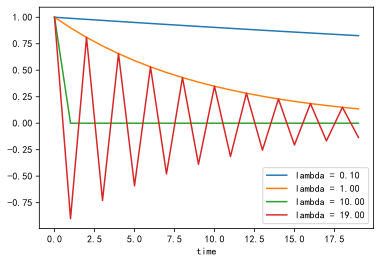

In [30]:
lambdas = [0.1, 1, 10, 19]
eta = 0.1
d2l.set_figsize((6, 4))
for lam in lambdas:
    t = torch.arange(20).detach().numpy()
    d2l.plt.plot(t, (1 - eta * lam) ** t, label=f'lambda = {lam:.2f}')
d2l.plt.xlabel('time')
d2l.plt.legend();

- 为了分析动量的收敛情况，我们首先用两个标量重写更新方程：一个用于$x$，另一个用于动量$v$。这产生了：
$$
\begin{bmatrix} v_{t+1} \\ x_{t+1} \end{bmatrix} =
\begin{bmatrix} \beta & \lambda \\ -\eta \beta & (1 - \eta \lambda) \end{bmatrix}
\begin{bmatrix} v_{t} \\ x_{t} \end{bmatrix} = \mathbf{R}(\beta, \eta, \lambda) \begin{bmatrix} v_{t} \\ x_{t} \end{bmatrix} \tag{11.6.12}
$$
- 用$\mathbf{R}$来表示$2 \times 2$管理的收敛表现。
- 在$t$步之后，最初的值$[v_0, x_0]$变为$\mathbf{R}(\beta, \eta, \lambda)^t [v_0, x_0]$。
- 因此，收敛速度是由$\mathbf{R}$的特征值决定的。
  - 简而言之，当$0 < \eta \lambda < 2 + 2 \beta$时动量收敛。
  - 与梯度下降的$0 < \eta \lambda < 2$相比，这是更大范围的可行参数。
- 另外，一般而言较大值的$\beta$是可取的。

- **要点：**
  - **考虑标量函数**: 我们考虑了一个特定的二次函数$f(x) = \frac{\lambda}{2} x^2$，并探讨了其优化过程。
  -  **梯度下降的更新规则**: 通过使用梯度下降的更新公式，可以推导出：
   $$
   x_{t+1} = (1 - \eta \lambda) x_t
   $$这里的$\eta$是学习率，$\lambda$与函数的特性有关。
  - **收敛条件**: 当$|1 - \eta \lambda| < 1$时，优化将以**指数速度收敛**。
    - 这意味着随着时间的推移，模型将快速逼近最优解。
  - **学习率的选择**: 增加学习率$\eta$将增加收敛速度，直到$\eta \lambda = 1$。
    - 之后，梯度可能开始发散，优化可能失控。
  - **动量的引入**: 通过引入动量项$v$，可以将问题重写为一个二维线性系统。
    - 这将允许更深入地了解动量如何影响收敛。
  - **动量的收敛分析**: 矩阵$\mathbf{R}$的特征值决定了动量优化的收敛性质。
    - 与纯梯度下降相比，动量允许更广泛的学习率选择，并且通常允许更大的$\beta$值。
  - **更宽的可行参数范围**: 动量方法比普通梯度下降允许更宽的参数范围，特别是当$0 < \eta \lambda < 2 + 2 \beta$时，它会收敛。
  - **较大的$\beta$值的可取性**: 在动量方法中，较大的$\beta$值通常是可取的，因为它有助于稳定优化过程。

## 小结

* 动量法用过去梯度的平均值来替换梯度，这大大加快了收敛速度。
* 对于无噪声梯度下降和嘈杂随机梯度下降，动量法都是可取的。
* 动量法可以防止在随机梯度下降的优化过程停滞的问题。
* 由于对过去的数据进行了指数降权，有效梯度数为$\frac{1}{1-\beta}$。
* 在凸二次问题中，可以对动量法进行明确而详细的分析。
* 动量法的实现非常简单，但它需要我们存储额外的状态向量（动量$\mathbf{v}$）。